# AIRDOS G data processing

In [49]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import glob
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


## Read Logfile

In [2]:
fto = '/storage/experiments/2020/1204_ABSJets/AIRDOS/DD/DATALOG.TXT' #  File to Open
#fto = '/storage/experiments/2020/1204_ABSJets/AIRDOS/98/DATALOG.TXT' #  File to Open

print (fto)

l=[]
#l.extend(range(0,261))
l.extend(range(0,258))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )
#df = pd.read_table(fto, sep=',', header=None,comment='*',engine='python' )

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

df.drop(df[df[0]=='$STROKE'].index, inplace=True)
df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)

sn = df.loc[df[0]=='$AIRDOS'][3]
print (sn[0])
#df.drop(df[df[0]=='$AIRDOS'].index, inplace=True)

# Convert strings to numbers
#df = df.apply(pd.to_numeric, errors='ignore')

#df.iloc[:,0:13]

#df

/storage/experiments/2020/1204_ABSJets/AIRDOS/DD/DATALOG.TXT
1290c00806a200912857a000a00000dd


## Derive measurement runs in to separate files

In [16]:
run = 0

runs = []
LatDD = np.nan
LatD = np.nan
LatM = np.nan
LonDD = np.nan
LonD = np.nan
LonM = np.nan

for i,r in df.iterrows():
    if (r[0] == '$AIRDOS'):
        run = run + 1
        date = np.nan #pd.to_datetime('210317000000.00', format='%d%m%y%H%M%S.%f')
        time = 0
        timedelta = 0
        timeoffset = 0
        datedate = pd.NaT
        altitude = np.nan
        Lat = np.nan
        Lon = np.nan
        speed = np.nan
        flag = 0
        flagrun = 0
        print (run, end='')
        
    if (r[0] == '$GPRMC'):
        date = pd.to_datetime(str(r[9])+str(r[1]), format='%d%m%y%H%M%S.%f',errors='coerce')
        speed = r[7]
        LatHem = r.astype(str)[4]
        LonHem = r.astype(str)[6]
        if (LatHem=='S'):     # Conferr DDMM.MM to DD.DD
            LatS = -1
        else:
            LatS = 1
        if (LonHem=='W'):
            LonS = -1
        else:
            LonS = 1
        Lat = float(r[3])
        LatD = np.trunc(Lat/100)
        LatM = ((Lat/100) - LatD) * 100
        LatDD = LatD + LatM/60.0
        LatDD = LatDD * LatS  
        Lon = float(r[5])
        LonD = np.trunc(Lon/100)
        LonM = ((Lon/100) - LonD) * 100
        LonDD = LonD + LonM/60.0
        LonDD = LonDD * LonS         
       
    if (r[0] == '$GPGGA'):
        altitude = r[9]

    if (r[0] == '$TIME'):
        if (not pd.isnull(date)) :
            flag = 1
            timeoffset = pd.to_numeric(r[1])
            datedate = date

    df.at[i,'date'] = date
    df.at[i,'altitude'] = altitude
    df.at[i,'speed'] = speed

    if (r[0] == '$CANDY'):
        time = pd.to_numeric(r[2])  # read seconds from power on
        if (flag == 1):
            timedelta = datedate
            if (flagrun == 0):
                runs.append([run,date,timedelta])
                flagrun = 1
            #flag = 0
        date_line = datedate + pd.to_timedelta(time - timeoffset, unit='s')
        
        try:
            df.at[i,'date'] = date_line
            df.at[i,'run'] = run
            df.at[i,'lat'] = LatDD
            df.at[i,'lon'] = LonDD
            df.at[i,'latD'] = LatD
            df.at[i,'lonD'] = LonD
            df.at[i,'latM'] = LatM
            df.at[i,'lonM'] = LonM
            df.at[i,'latHem'] = LatHem
            df.at[i,'lonHem'] = LonHem
        except:
            pass
        
  
FROM = pd.to_datetime('2019-11-27 00:00:00')
TO = pd.to_datetime('2019-11-29 01:10:00')
#FROM = pd.to_datetime('2019-11-28 18:55:00')
#TO = pd.to_datetime('2019-11-29 01:00:00')
#PRG-AGP
#FROM = pd.to_datetime('2019-11-28 18:55:00')
#TO = pd.to_datetime('2019-11-28 20:55:00')
#AGP-PRG
#FROM = pd.to_datetime('2019-11-28 23:00:00')
#TO = pd.to_datetime('2019-11-29 00:30:00')


dfo = df.copy()
#dfo = dfo.loc[(dfo['date']>FROM)&(dfo['date']<TO)]

#01/2002, FL-27
#DEG MIN N/S DEG MIN E/W FEET TIME(MIN)
dfdeg = df[['latD','latM','latHem','lonD','lonM','lonHem','altitude','run','date']].copy()
dfdeg['altitude'] *= 3.28084
dfdeg['minute'] = 0
dfo['minute'] = 0
dfdeg = dfdeg.loc[(dfdeg['date']>FROM)&(dfdeg['date']<TO)]
#dfdeg.reset_index(inplace=True)

dfo.drop(dfo[dfo[0]=='$GPRMC'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$GPGGA'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$AIRDOS'].index, inplace=True)
dfdeg.drop(dfo[dfo[0]=='$GPRMC'].index, inplace=True)
dfdeg.drop(dfo[dfo[0]=='$GPGGA'].index, inplace=True)
dfdeg.drop(dfo[dfo[0]=='$AIRDOS'].index, inplace=True)

'''
TODO !!!!!!!!!!!!!!!!!!!!
# calculate empty dates
for x in runs:
    print x
    dfo.loc[(dfo['date'].isnull())&(dfo['run'] == x[0]),'TBD'] = x[0]
    dfo.loc[dfo['TBD'] == x[0],'time'] = pd.to_datetime(x[1] + (pd.to_timedelta(pd.to_numeric(dfo.loc[dfo['TBD'] == x[0],2]), unit='s')) - pd.to_timedelta(x[2], unit='s'))
    dfo.loc[(dfo['time'].isnull())&(dfo['run'] == x[0]),'time'] = dfo.loc[(dfo['time'].isnull())&(dfo['run'] == x[0]),'date']

dfo.drop(['TBD','date'], axis = 1, inplace = True, errors = 'ignore')
'''
print ()

for f in glob.iglob("./output/*.csv"): # delete all output files 
    print ('Deleting', f)
    #os.remove(f)


dfo.set_index('date', inplace = True)

#01/2002, FL-27
#DEG MIN N/S DEG MIN E/W FEET TIME(MIN)

for x in runs: 
    filename = './output/' + str(timedelta) + '_' + str(sn[0])

    # Disimetric values
    #dfo.loc[dfo['run'] == x[0],'minute'] = (pd.to_timedelta(dfo.loc[dfo['run'] == x[0]].index-(x[1] + pd.to_timedelta(-x[2], unit='s')))).astype('timedelta64[m]').fillna(0).astype(int)
    dfo.loc[dfo['run'] == x[0]].to_csv(filename + '.csv')


print('End')

1
Deleting ./output/2020-12-04 15:16:10_1290c00806a200912821a000a0000098.csv
End


## Plot Flux

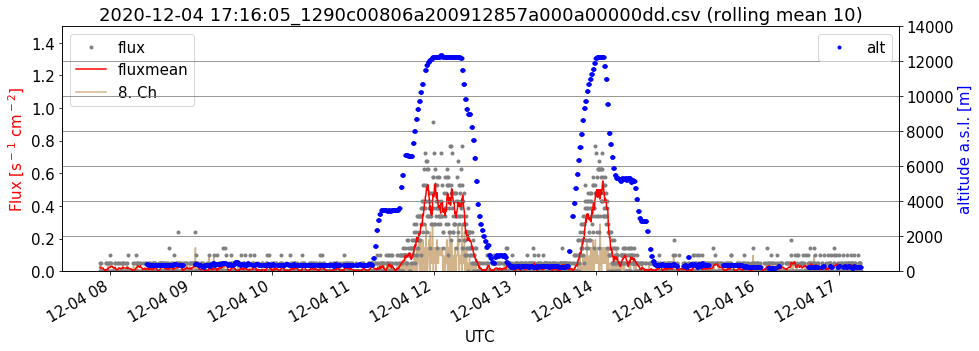

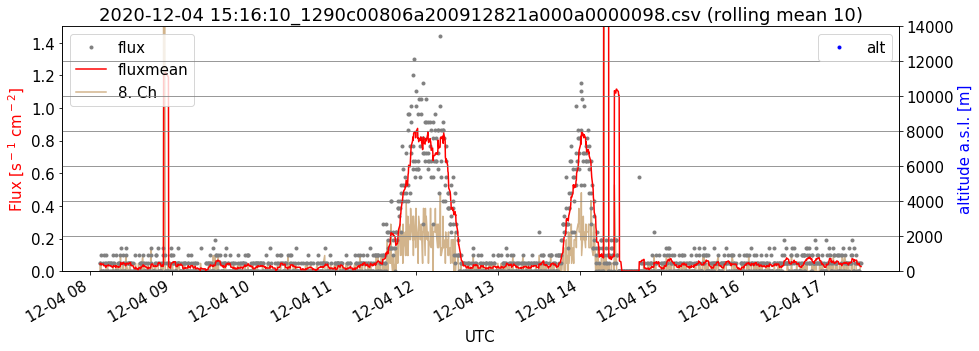

In [50]:
matplotlib.rcParams.update({'font.size': 15})

NOISE_LEVEL= 8
LAST_CHANNEL=254
WINDOW = 10

for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    try:
        plt.figure(figsize=(15,5))
        plt.tight_layout()
        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        #xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']

        
        xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))/2/10.4

        xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

        xx['flux'].plot(c='gray', linestyle='', marker='.')
        xx['fluxmean'].plot(c='red')
        (xx.iloc[:,NOISE_LEVEL]/2/10.4).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

        s = f.split('/')
        plt.title(s[len(s)-1] + ' (rolling mean ' + str(WINDOW) + ')')
        plt.ylim([0,1.5])
        plt.xlabel('UTC')
        plt.ylabel(r'Flux [s$^-$$^1$ cm$^-$$^2$]', color='red')
        plt.legend(loc=2)

        ax = plt.twinx()
                
        plt.ylim([0,14000])
        xx['altitude'].plot(c='b', label='alt', marker='.', linewidth='2', linestyle='none', drawstyle='steps-mid')
        plt.ylabel('altitude a.s.l. [m]', color='blue')

        plt.grid(b=True, which='major', color='grey', linestyle='-')
        plt.grid(b=True, which='minor', color='grey', linestyle='-')
        plt.legend()
    except:
        pass



## Plot Energy Spectra

0.03850279329608939 -0.040592178770949686


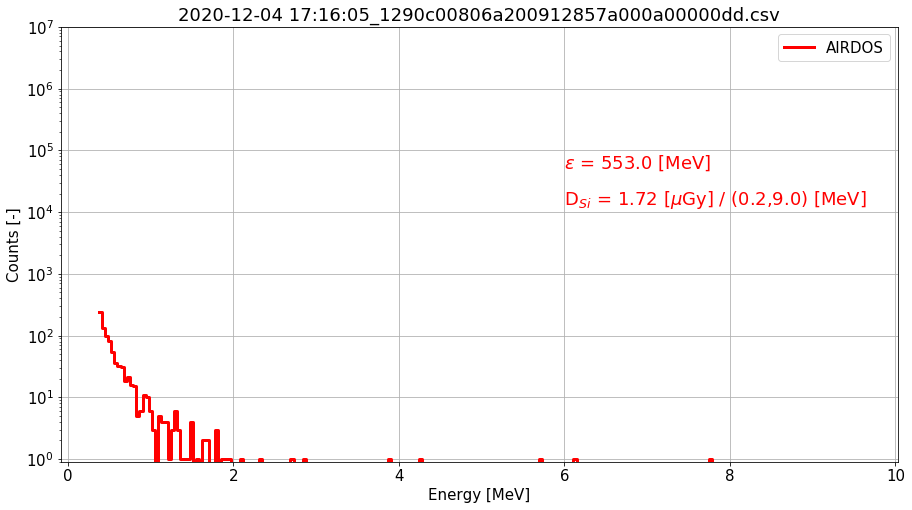

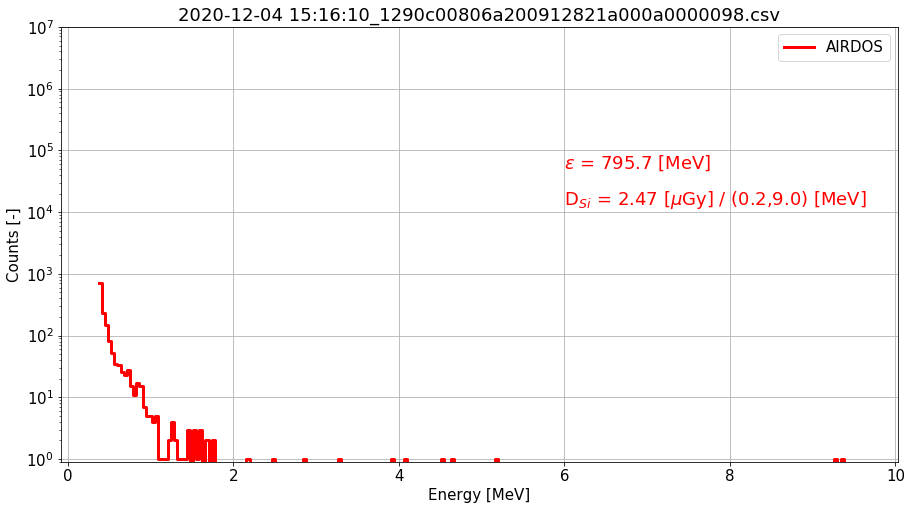

In [3]:
matplotlib.rcParams.update({'font.size': 15})

FROM_ENERGY = 0.2
TO_ENERGY = 9.0

l = np.array([[29+4, 1],[208+4,1]]) # Calibration
r = np.array([1.23, 8.122])
coef = np.linalg.solve(l,r)
print (coef[0], coef[1])

# force calibration coeficients
coef[0]=0.038
coef[1]=0.105
    
    
for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    try:        
        LOW_ENERGY = 7
        
        df = pd.read_csv(f)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace = True)
        
        # Uncomment this if you are interested in a specific time interval
        #xx = df.loc['2019-01-24 05:00:00':'2019-01-24 13:00:00']
        #from 2019-11-28 18:55 to 2019-11-28 20:55 was used for the flight PRG-AGP
        #from 2019-11-28 23:00 to 2019-11-29 00:30 was used for the flight AGP-PRG
        xx = df.loc['2020-12-04 12:00:00':'2020-12-04 12:18:00']
        #xx = df
        ener1 = xx.iloc[:,LOW_ENERGY:250].sum()
        e = pd.DataFrame()
        e['1'] = ener1
        e['index'] = pd.to_numeric(ener1.index)
        e['x'] = (e['index']) * coef[0] + coef[1]
        e['deposit'] = e['1'] * e['x']
        depener = e.loc[(e['x']>=FROM_ENERGY)&(e['x']<=TO_ENERGY),'deposit'].sum() # MeV

        dose = (1e6*(1.602e-19 * depener*1e6)/0.1398e-3) #* 1.1

        # size of the chip (20 mm · 10 mm), 
        # the thickness of the depletion layer (0.3 mm), 
        # and the density of silicon (2.33 g cm^3)
        # 0.1398e-3 kg
        #dose = ((1e6 * (1.602e-19 * depener * 1e6)/0.1398e-3)/10.4) * 3600 * 2.71 # in uGy/h
        
        
        if (depener > 0):
            plt.figure(figsize=(15,8))
            plt.tight_layout()
            s = f.split('/')
            plt.title(s[len(s)-1])
            plt.yscale('log')
            plt.ylim([0.9,1e7])

            plt.plot(e['x'],e['1'], c='r', lw=3, drawstyle='steps-post', label='AIRDOS')

            plt.text(6, 50000, r'$\epsilon$ = ' + str(round(depener*1.1,1)) + ' [MeV]', fontsize=18, color='r')
            plt.text(6, 13000, r'D$_S$$_i$ = ' + str(round(dose*1.1*2.71,2)) + r' [$\mu$Gy] / (' + str(FROM_ENERGY) + ',' + str(TO_ENERGY) + ') [MeV]', fontsize=18, color='r')

            plt.legend()
            plt.xlabel('Energy [MeV]')
            plt.ylabel('Counts [-]')
            plt.grid()
    except:
        pass


## Plot Dose-rate in Silicon

dd.csv
2020-12-04 17:16:05_1290c00806a200912857a000a00000dd.csv
        4    5  6  7  8  9
10  12720  709  3  0  0  0
11  12888  706  4  0  0  0
Window = 104.0 [s]
Mean Doserate from rolling mean values = 2.02 [μGy/h]
Mean Doserate = 2.01 [μGy/h]
Standard deviation from rolling mean values = 0.25

98.csv
2020-12-04 15:16:10_1290c00806a200912821a000a0000098.csv
      4        5     6   7    8  9
10  1.0  16672.0  5026  16  0.0  0
11  0.0  16596.0  5137   9  0.0  0
Window = 104.0 [s]
Mean Doserate from rolling mean values = 4.35 [μGy/h]
Mean Doserate = 4.27 [μGy/h]
Standard deviation from rolling mean values = 0.48



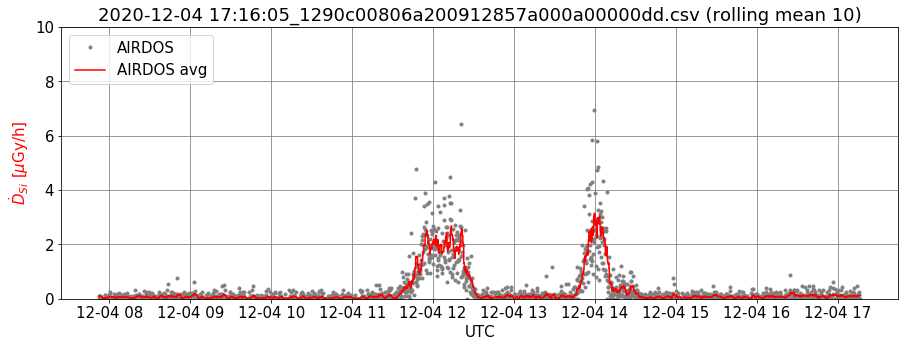

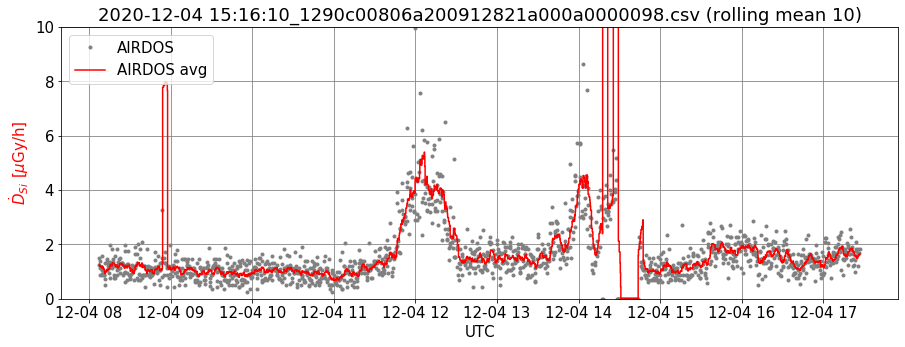

In [48]:
matplotlib.rcParams.update({'font.size': 15})

NOISE_LEVEL= 8     #  8 for DD, 9 for 98
BASE_ENERGY = 3
LAST_CHANNEL=254
WINDOW = 10

for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    plt.figure(figsize=(15,5))
    plt.tight_layout()
    xx = pd.read_csv(f)
    xx['date'] = pd.to_datetime(xx['date'])
    #xx.set_index('date', inplace = True)
    #xx = xx.loc['2020-12-04 12:00:00':'2020-12-04 12:18:00']

    s = f.split('/')
    plt.title(s[len(s)-1] + ' (rolling mean ' + str(WINDOW) + ')')
    print(s[len(s)-1][-6:])
        
    # Deposited energy
    e = pd.DataFrame()
    e['Ch']=range(0,256)
    e['ener'] = e.index * 0.038 + 0.105
    xx['ener'] = (np.asarray(xx.iloc[:,NOISE_LEVEL:NOISE_LEVEL+253-8]) * np.asarray(e.loc[3:247,'ener'])).sum(axis=1)    
    
    print(s[len(s)-1])
    print(xx.iloc[10:12,NOISE_LEVEL-3:NOISE_LEVEL+3])

    # size of the chip (20 mm · 10 mm), 
    # the thickness of the depletion layer (0.3 mm), 
    # and the density of silicon (2.33 g cm^3)
    # 0.1398e-3 kg
    xx['dsi'] = ((1e6 * (1.602e-19 * xx['ener'] * 1e6)/0.1398e-3)/10.4) * 3600 # in uGy/h

    xx['dsimean'] = xx['dsi'].rolling(WINDOW).mean()
    #xx.dropna(how='any', inplace=True)

    #plt.plot(xx['minute'], xx['flux'], c='gray', linestyle='', marker='.')
    plt.plot(xx['date'], xx['dsi'], c='gray', linestyle='', marker='.', label='AIRDOS')
    plt.plot(xx['date'],xx['dsimean'],c='red', drawstyle='steps-mid', label='AIRDOS avg')
    #plt.plot(xx.iloc[:,'minute'],xx['fluxmean']c='red')
    #plt.plot(xx.loc[:,'minute'],xx.iloc[:,NOISE_LEVEL],c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

    plt.ylim([0,10])
    #plt.yscale('log')

    plt.xlabel('UTC')
    plt.ylabel(r'$\.D$$_S$$_i$ [$\mu$Gy/h]', color='red')
    plt.legend(loc=2)

    plt.grid(b=True, which='major', color='grey', linestyle='-')
    plt.grid(b=True, which='minor', color='grey', linestyle='-')

    dose = xx.copy()
    dose.set_index('date', inplace=True)

    # Calculation of doserate for given time period
    dose = dose.loc['2020-12-04 12:00:00':'2020-12-04 12:18:00']

    print('Window =', WINDOW * 10.4, '[s]' )
    print('Mean Doserate from rolling mean values =', round(dose.dsimean.mean(), 2), '[\u03BCGy/h]' )
    print('Mean Doserate =', round(dose.dsi.mean(), 2), '[\u03BCGy/h]' )
    print('Standard deviation from rolling mean values =', round(dose.dsimean.std(), 2))
    print()


### Plot Map

In [31]:
xx.iloc[:,7:]

,6,7,8,9,10,11,12,13,14,15,...,latD,lonD,latM,lonM,latHem,lonHem,minute,ener,dsi,dsimean
0,4,0,0,1,0,0.0,0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.257,0.101943,NaN
1,4,0,0,1,1,0.0,0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.552,0.218959,NaN
2,3,0,0,0,0,0.0,0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.979,0.388336,NaN
3,2,0,1,0,0,0.0,0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.219,0.086870,NaN
4,4,1,0,0,0,0.0,0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2353,7,0,0,0,0,0.0,0,0.0,0.0,0.0,...,50.0,14.0,6.97776,27.62958,N,E,0,0.561,0.222529,0.087795
2354,7,0,0,0,1,0.0,0,0.0,0.0,0.0,...,50.0,14.0,6.97776,27.62958,N,E,0,0.295,0.117016,0.088298
2355,4,0,0,0,0,0.0,0,0.0,0.0,0.0,...,50.0,14.0,6.98924,27.62664,N,E,0,0.000,0.000000,0.088298
2356,4,0,0,0,0,0.0,0,0.0,0.0,0.0,...,50.0,14.0,6.98924,27.62664,N,E,0,0.000,0.000000,0.088298


<Figure size 1080x360 with 0 Axes>

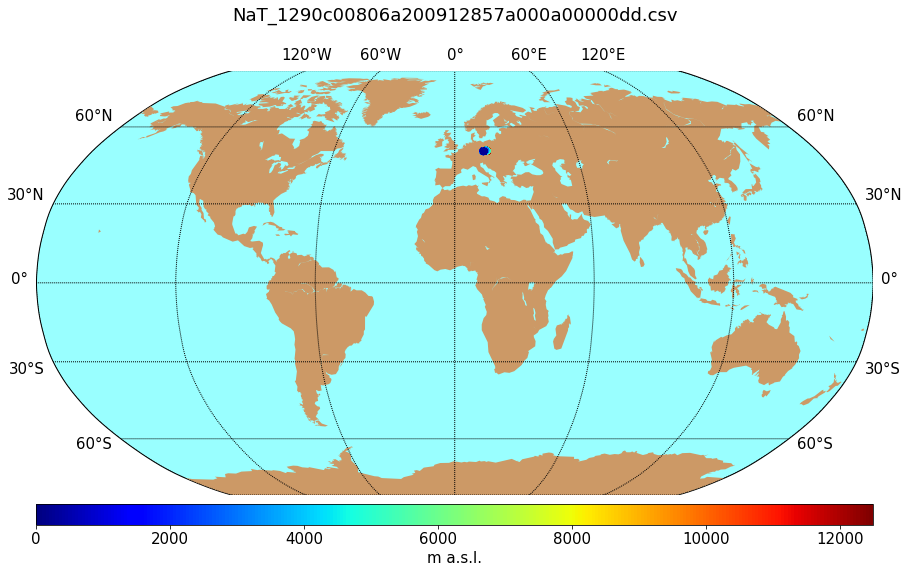

In [47]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os

NOISE_LEVEL= 7
LAST_CHANNEL=254
WINDOW = 10

for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    try:
        plt.figure(figsize=(15,5))
        plt.tight_layout()
        df6 = pd.read_csv(f)
        df6.dropna(inplace=True)
        df6['lat'] = pd.to_numeric(df6['lat'])
        df6['lon'] = pd.to_numeric(df6['lon'])
        df6['altitude'] = pd.to_numeric(df6['altitude'])
        
        plt.figure(figsize=(15,15))
        matplotlib.rcParams.update({'font.size': 15})

        # create Basemap instance.
        #m = Basemap(projection='kav7',lon_0=0)
        #m = Basemap(projection='cea',lon_0=0)
        m = Basemap(projection='robin',lon_0=0)
        #m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,projection='mill')

        x, y = m(df6.lon.tolist(),df6.lat.tolist())
        m.drawmapboundary(fill_color='#99ffff')
        m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
        # draw parallels and meridians, but don't bother labelling them.
        m.drawparallels(np.arange(-90.,99.,30.),labels=[1,1,0,0])
        m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,1,0])
        
        im1 = m.scatter(x,y,c=df6.altitude.tolist(),marker='o', cmap='jet')
        cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
        cb.set_label('m a.s.l.')
        
        s = f.split('/')
        plt.title(s[len(s)-1], pad=50)

        plt.clim(0, 12500)  # limit for color axis
        plt.show()                
    except:
        pass


<Figure size 1080x360 with 0 Axes>

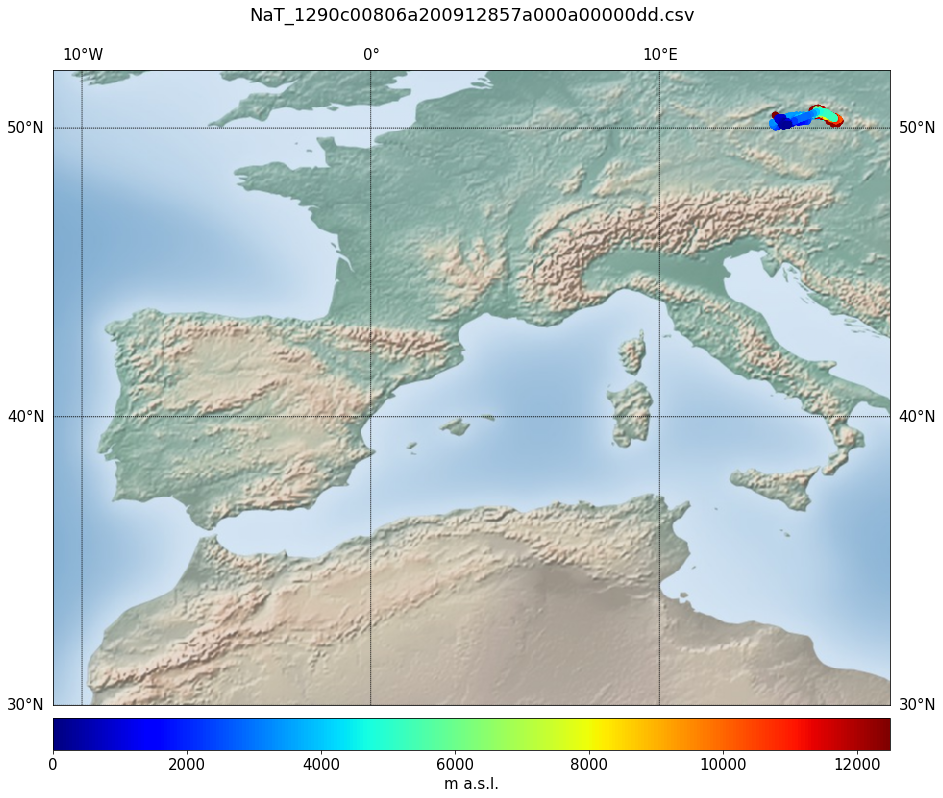

In [46]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os

NOISE_LEVEL= 7
LAST_CHANNEL=254
WINDOW = 10

for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    try:
        plt.figure(figsize=(15,5))
        plt.tight_layout()
        df6 = pd.read_csv(f)
        df6.dropna(inplace=True)
        df6['lat'] = pd.to_numeric(df6['lat'])
        df6['lon'] = pd.to_numeric(df6['lon'])
        df6['altitude'] = pd.to_numeric(df6['altitude'])
        
        plt.figure(figsize=(15,15))
        matplotlib.rcParams.update({'font.size': 15})

        # create Basemap instance.
        #m = Basemap(projection='kav7',lon_0=0)
        #m = Basemap(projection='cea',lon_0=0)
        #m = Basemap(projection='robin',lon_0=0)
        #m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,projection='mill')
        m = Basemap(projection='cyl',lon_0=0, llcrnrlon=-11,llcrnrlat=30,urcrnrlon=18,urcrnrlat=52)

        x, y = m(df6.lon.tolist(),df6.lat.tolist())
        #m.drawmapboundary(fill_color='#99ffff')
        m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
        # draw parallels and meridians, but don't bother labelling them.
        m.drawparallels(np.arange(-90.,99.,10.),labels=[1,1,0,0])
        m.drawmeridians(np.arange(-180.,180.,10.),labels=[0,0,1,0])
        m.shadedrelief()
        
        m.plot(x,y, zorder=2, color='gray', lw=5)
        im1 = m.scatter(x,y,c=df6.altitude.tolist(),marker='o', cmap='jet', zorder=99)

        cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
        cb.set_label('m a.s.l.')
        
        s = f.split('/')
        plt.title(s[len(s)-1], pad=50)

        plt.clim(0, 12500)  # limit for color axis
        plt.show()                
    except:
        pass


dd.csv
2020-12-04 17:16:05_1290c00806a200912857a000a00000dd.csv
      5  6  7  8  9  10
10  709  3  0  0  0   0
11  706  4  0  0  0   0
Window = 104.0 [s]
Mean Doserate from rolling mean values = 1.59 [μGy/h]
Mean Doserate = 1.57 [μGy/h]
Standard deviation from rolling mean values = 0.24

98.csv
2020-12-04 15:16:10_1290c00806a200912821a000a0000098.csv
          5     6   7    8  9   10
10  16672.0  5026  16  0.0  0  0.0
11  16596.0  5137   9  0.0  0  0.0
Window = 104.0 [s]
Mean Doserate from rolling mean values = 2.7 [μGy/h]
Mean Doserate = 2.69 [μGy/h]
Standard deviation from rolling mean values = 0.42



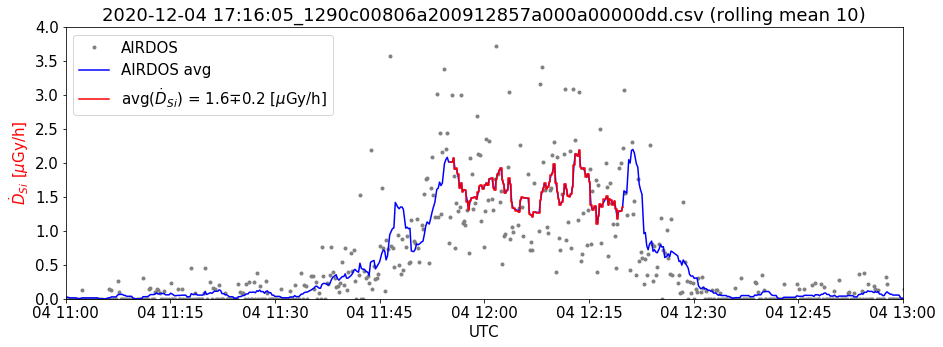

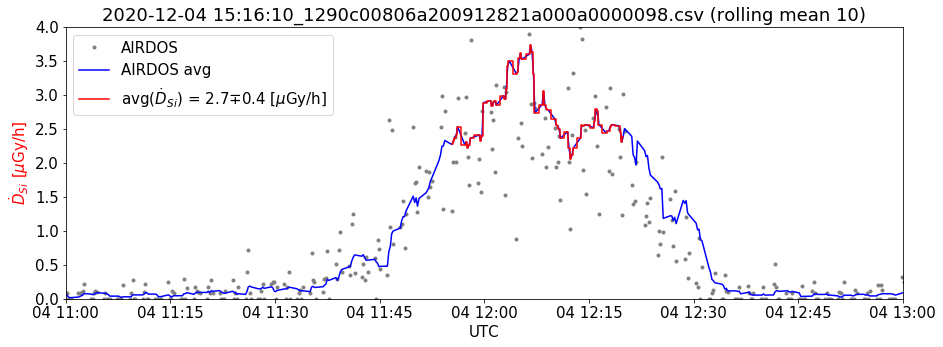

In [81]:
matplotlib.rcParams.update({'font.size': 15})

NOISE_LEVEL= 9     #  8 for DD, 9 for 98
BASE_ENERGY = 3
LAST_CHANNEL=254
WINDOW = 10

for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    plt.figure(figsize=(15,5))
    plt.tight_layout()
    xx = pd.read_csv(f)
    xx['date'] = pd.to_datetime(xx['date'])
    #xx.set_index('date', inplace = True)
    #xx = xx.loc['2020-12-04 12:00:00':'2020-12-04 12:18:00']

    s = f.split('/')
    plt.title(s[len(s)-1] + ' (rolling mean ' + str(WINDOW) + ')')
    print(s[len(s)-1][-6:])
        
    # Deposited energy
    e = pd.DataFrame()
    e['Ch']=range(0,256)
    e['ener'] = e.index * 0.038 + 0.105
    xx['ener'] = (np.asarray(xx.iloc[:,NOISE_LEVEL:NOISE_LEVEL+253-8]) * np.asarray(e.loc[3:247,'ener'])).sum(axis=1)    
    
    print(s[len(s)-1])
    print(xx.iloc[10:12,NOISE_LEVEL-3:NOISE_LEVEL+3])

    # size of the chip (20 mm · 10 mm), 
    # the thickness of the depletion layer (0.3 mm), 
    # and the density of silicon (2.33 g cm^3)
    # 0.1398e-3 kg
    xx['dsi'] = ((1e6 * (1.602e-19 * xx['ener'] * 1e6)/0.1398e-3)/10.4) * 3600 # in uGy/h

    xx['dsimean'] = xx['dsi'].rolling(WINDOW).mean()
    #xx.dropna(how='any', inplace=True)

    plt.plot(xx['date'], xx['dsi'], c='gray', linestyle='', marker='.', label='AIRDOS')
    #plt.plot(xx['date'],xx['dsimean'],c='red', drawstyle='steps-mid', label='AIRDOS avg')
    plt.plot(xx['date'],xx['dsimean'],c='blue', label='AIRDOS avg')

    plt.ylim([0,4])
    #plt.yscale('log')

    plt.xlabel('UTC')
    plt.ylabel(r'$\.D$$_S$$_i$ [$\mu$Gy/h]', color='red')

    #plt.grid(b=True, which='major', color='grey', linestyle='-')
    #plt.grid(b=True, which='minor', color='grey', linestyle='-')

    dose = xx.copy()
    dose.set_index('date', inplace=True)

    # Calculation of doserate for given time period
    dose = dose.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']


    print('Window =', WINDOW * 10.4, '[s]' )
    print('Mean Doserate from rolling mean values =', round(dose.dsimean.mean(), 2), '[\u03BCGy/h]' )
    print('Mean Doserate =', round(dose.dsi.mean(), 2), '[\u03BCGy/h]' )
    print('Standard deviation from rolling mean values =', round(dose.dsimean.std(), 2))
    print()

    plt.xlim(pd.to_datetime('2020-12-04 11:00:00'),pd.to_datetime('2020-12-04 13:00:00'))
    plt.plot(dose.index,dose['dsimean'],c='red', drawstyle='steps-mid', label=r'avg($\.D$$_S$$_i$) = '+ str(round(dose.dsimean.mean(), 1)) + '$\mp$' + str(round(dose.dsimean.std(), 1)) + ' [$\mu$Gy/h]')
    plt.legend(loc=2)


In [58]:
dose


,0,1,2,3,4,5,6,7,8,9,...,latD,lonD,latM,lonM,latHem,lonHem,minute,ener,dsi,dsimean
date,,,,,,,,,,,,,,,,,,,,,
2020-12-04 12:00:06,$CANDY,1031,15211,6874,12794,725,11,5,2,3,...,50.0,15.0,40.74005,27.46976,N,E,0,4.729,1.875831,2.104192
2020-12-04 12:00:18,$CANDY,1032,15223,6822,12849,689,11,1,2,1,...,50.0,15.0,40.74005,27.46976,N,E,0,6.734,2.671146,2.152585
2020-12-04 12:00:30,$CANDY,1033,15235,6853,12741,766,9,4,1,0,...,50.0,15.0,40.74005,27.46976,N,E,0,4.774,1.893681,2.088841
2020-12-04 12:00:42,$CANDY,1034,15247,6856,12799,723,4,1,3,1,...,50.0,15.0,40.74005,27.46976,N,E,0,6.504,2.579913,2.184596
2020-12-04 12:01:06,$CANDY,1035,15271,6963,12707,694,7,2,2,4,...,50.0,15.0,37.13430,18.12722,N,E,0,4.653,1.845685,2.169523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-04 12:16:46,$CANDY,1099,16211,6685,12953,722,13,5,2,2,...,50.0,15.0,37.54655,39.07300,N,E,0,3.426,1.358976,1.752508
2020-12-04 12:17:23,$CANDY,1100,16248,6732,12919,709,12,2,2,1,...,50.0,15.0,40.21533,27.84865,N,E,0,5.916,2.346673,1.872817
2020-12-04 12:17:35,$CANDY,1101,16260,6689,12934,707,9,4,6,1,...,50.0,15.0,40.21533,27.84865,N,E,0,5.538,2.196734,1.926882
